In [378]:
# 1. Imports
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import optuna

# modeling
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.special import logit, expit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# PyTorch for conversion model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# nfl pbp loader
import nfl_data_py as nfl

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# 2a. Download PBP (this can take a few minutes)
seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
print("Loading play-by-play for seasons:", seasons)
raw_pbp = nfl.import_pbp_data(seasons, downcast=False)  # returns a DataFrame (may be large)

print("Rows loaded:", raw_pbp.shape[0])
raw_pbp.head()

Loading play-by-play for seasons: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2024 done.
Rows loaded: 433940


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers
0,1.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def parse_weather(weather_str):
    """
    Parses a weather string into structured features:
        - temp_F: float
        - humidity: float (percentage)
        - wind_mph: float
        - wind_dir: str
        - conditions: str (general description, e.g., 'sunny', 'cloudy', etc.)
    """
    result = {
        "temp_F": None,
        "humidity": None,
        "wind_mph": None,
        "wind_dir": None,
        "conditions": None
    }
    
    if not isinstance(weather_str, str):
        return result
    
    lower_str = weather_str.lower()
    
    # Extract temperature
    temp_match = re.search(r'(\d+)\s*°?\s*f', lower_str)
    if temp_match:
        result['temp_F'] = float(temp_match.group(1))
    
    # Extract humidity
    hum_match = re.search(r'humidity[:\s]*(\d+)%', lower_str)
    if hum_match:
        result['humidity'] = float(hum_match.group(1))
    
    # Extract wind speed and direction
    wind_match = re.search(r'wind[:\s]*([nesw]+)\s*(\d+)\s*mph', lower_str)
    if wind_match:
        result['wind_dir'] = wind_match.group(1).upper()
        result['wind_mph'] = float(wind_match.group(2))
    
    # Extract general conditions
    conditions = []
    for cond in ['sunny', 'cloudy', 'clear', 'rain', 'snow', 'fog', 'drizzle', 'storm', 'windy']:
        if cond in lower_str:
            conditions.append(cond)
    if conditions:
        result['conditions'] = ','.join(conditions)
    
    return result


def deconstruct_weather(df, weather_col='weather'):
    """
    Adds structured weather columns to a DataFrame based on a weather string column.
    
    New columns added:
      - temp_F
      - humidity
      - wind_mph
      - wind_dir
      - conditions
    """
    weather_data = df[weather_col].apply(parse_weather)
    weather_df = pd.DataFrame(weather_data.tolist())
    df = pd.concat([df.reset_index(drop=True), weather_df], axis=1)
    
    # Fill missing wind speeds with 0
    df['wind_mph'] = df['wind_mph'].fillna(0)

    # Fill missing temperatures with 60°F
    df['temp_F'] = df['temp_F'].fillna(60)

    return df

In [4]:
pbp = raw_pbp.copy()
pbp = deconstruct_weather(pbp)

In [5]:
pbp = pbp[pbp.penalty == 0]  # remove penalty plays

# --- Drop rows missing home/away WP ---
wp_df = pbp.dropna(subset=["home_wp_post", "away_wp_post"]).copy()

# --- Define features ---
wp_df["score_time_ratio"] = wp_df["score_differential"].abs() / (wp_df["game_seconds_remaining"] + 1)
wp_features = [
    "yardline_100",
    "down",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

# --- Define posteam WP target ---
wp_df["wp_target"] = np.where(
    wp_df["posteam"] == wp_df["home_team"],
    wp_df["home_wp_post"],
    wp_df["away_wp_post"]
)

X_wp = wp_df[wp_features]
y_wp = wp_df["wp_target"]

# --- Clip target to avoid exact 0/1 ---
epsilon = 1e-6
y_wp_clipped = y_wp.clip(epsilon, 1 - epsilon)

# --- Train-test split ---
Xwp_train, Xwp_test, ywp_train, ywp_test = train_test_split(
    X_wp, y_wp_clipped, test_size=0.2, random_state=42
)

# --- Monotone constraints (time variables unconstrained now) ---
monotone_constraints_dict = {
    "yardline_100": -1,               # closer to opponent endzone → WP ↑
    "down": -1,                       # higher down (worse) → WP ↓
    "ydstogo": -1,                    # more yards to go → WP ↓
    "score_differential": 1,          # lead → WP ↑
    "posteam_timeouts_remaining": 1,  # more TOs → WP ↑
    "defteam_timeouts_remaining": -1  # opponent TOs → WP ↓
}

# --- Train XGBoost regressor ---
wp_model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    verbosity=0,
    monotone_constraints=monotone_constraints_dict
)

wp_model.fit(Xwp_train, ywp_train, eval_set=[(Xwp_test, ywp_test)], verbose=False)

# --- Evaluate test RMSE ---
preds = wp_model.predict(Xwp_test)
rmse = np.sqrt(np.mean((preds - y_wp.loc[Xwp_test.index].values)**2))
print("WP test RMSE:", rmse)


def predict_wp(state_df):
    # Compute score_time_ratio if missing
    if "score_time_ratio" not in state_df:
        state_df["score_time_ratio"] = state_df["score_differential"].abs() / (state_df["game_seconds_remaining"] + 1)
    
    preds = wp_model.predict(state_df[wp_features])
    return np.clip(preds, 0.0, 1.0)

WP test RMSE: 0.059866887648509975


In [6]:
def flip_possession(state):
    """
    Flip possession for WP prediction.
    Returns a new state dict from the perspective of the new posteam.
    """
    new_state = state.copy()
    # Negate score differential
    new_state["score_differential"] = -state["score_differential"]
    # Swap timeouts
    new_state["posteam_timeouts_remaining"] = state["defteam_timeouts_remaining"]
    new_state["defteam_timeouts_remaining"] = state["posteam_timeouts_remaining"]
    return new_state

In [7]:
# Filter to punts only
punt_df = pbp[pbp.play_type == "punt"].dropna(subset=["kick_distance", "return_yards"]).copy()

# Compute net punt yardage: kick distance minus return yards, adjust for touchbacks (if available)
# Assuming touchback puts ball at 20-yard line
punt_df["net_punt"] = punt_df["kick_distance"] - punt_df["return_yards"]
punt_df.loc[punt_df["touchback"] == 1, "net_punt"] = punt_df["yardline_100"] - 20

# Features to predict net punt
punt_features = [
    "yardline_100", 
    "game_seconds_remaining", 
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

X = punt_df[punt_features].values
y = punt_df["net_punt"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_valid_t = torch.tensor(X_valid, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)

# --- Define objective for Optuna ---
def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)

    # Build network dynamically
    layers = []
    input_dim = X_train.shape[1]
    for i in range(n_layers):
        layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(hidden_size, 1))
    layers.append(nn.Sigmoid())
    
    model = nn.Sequential(*layers)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    epochs = 50  # keep small for quick trials
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()
    
    # Validation loss
    model.eval()
    with torch.no_grad():
        val_preds = model(X_valid_t)
        val_loss = criterion(val_preds, y_valid_t).item()
    
    return val_loss

# --- Create and run study ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best validation loss:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-12-16 22:32:43,284] A new study created in memory with name: no-name-44a85c13-fb81-4e89-a89d-2222834223e2
[I 2025-12-16 22:32:44,446] Trial 0 finished with value: -3922.019287109375 and parameters: {'n_layers': 2, 'hidden_size': 88, 'lr': 0.0032490847394939953, 'dropout': 0.12060976712948335}. Best is trial 0 with value: -3922.019287109375.
[I 2025-12-16 22:32:44,820] Trial 1 finished with value: -186.85272216796875 and parameters: {'n_layers': 1, 'hidden_size': 60, 'lr': 0.003131521127435422, 'dropout': 0.15836911820281102}. Best is trial 0 with value: -3922.019287109375.
[I 2025-12-16 22:32:45,763] Trial 2 finished with value: -11.964405059814453 and parameters: {'n_layers': 2, 'hidden_size': 80, 'lr': 0.00012922808883866408, 'dropout': 0.4558956039992511}. Best is trial 0 with value: -3922.019287109375.
[I 2025-12-16 22:32:47,197] Trial 3 finished with value: -19.14337921142578 and parameters: {'n_layers': 3, 'hidden_size': 76, 'lr': 0.00024179706318284925, 'dropout': 0.3558

[I 2025-12-16 22:33:26,757] Trial 33 finished with value: -3922.019287109375 and parameters: {'n_layers': 2, 'hidden_size': 113, 'lr': 0.002860361783233622, 'dropout': 0.19999082396636544}. Best is trial 0 with value: -3922.019287109375.
[I 2025-12-16 22:33:27,722] Trial 34 finished with value: -3922.019287109375 and parameters: {'n_layers': 2, 'hidden_size': 74, 'lr': 0.007084793116076652, 'dropout': 0.20536100953769504}. Best is trial 0 with value: -3922.019287109375.
[I 2025-12-16 22:33:29,141] Trial 35 finished with value: -3922.019287109375 and parameters: {'n_layers': 2, 'hidden_size': 119, 'lr': 0.0038712563776789797, 'dropout': 0.1321687760217935}. Best is trial 0 with value: -3922.019287109375.
[I 2025-12-16 22:33:29,871] Trial 36 finished with value: -448.462646484375 and parameters: {'n_layers': 1, 'hidden_size': 128, 'lr': 0.002744479945231232, 'dropout': 0.21588753150080664}. Best is trial 0 with value: -3922.019287109375.
[I 2025-12-16 22:33:30,789] Trial 37 finished with

Best validation loss: -3922.019287109375
Best hyperparameters: {'n_layers': 2, 'hidden_size': 88, 'lr': 0.0032490847394939953, 'dropout': 0.12060976712948335}


In [8]:
best_params = study.best_params
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout"]

layers = []
input_dim = len(punt_features)

for i in range(n_layers):
    layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))

layers.append(nn.Linear(hidden_size, 1))
punt_model = nn.Sequential(*layers)

X = punt_df[punt_features].values
y = punt_df["net_punt"].values.reshape(-1, 1)

scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_t = torch.tensor(X_scaled, dtype=torch.float32)
y_t = torch.tensor(y_scaled, dtype=torch.float32)

optimizer = torch.optim.Adam(punt_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

punt_model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    preds = punt_model(X_t)
    loss = loss_fn(preds, y_t)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

punt_model.eval()

def predict_punt(state_dict):
    """
    Returns predicted NET punt yards (float)
    """

    x = np.array([state_dict[f] for f in punt_features]).reshape(1, -1)
    x_scaled = scaler.transform(x)
    x_t = torch.tensor(x_scaled, dtype=torch.float32)

    with torch.no_grad():
        y_scaled_pred = punt_model(x_t).item()

    net_punt = y_scaler.inverse_transform([[y_scaled_pred]])[0, 0]

    return float(net_punt)

Epoch 0, Loss 1.0232
Epoch 100, Loss 0.8571
Epoch 200, Loss 0.8506
Epoch 300, Loss 0.8442
Epoch 400, Loss 0.8389
Epoch 500, Loss 0.8314
Epoch 600, Loss 0.8269
Epoch 700, Loss 0.8230
Epoch 800, Loss 0.8176
Epoch 900, Loss 0.8121


In [9]:
def evaluate_punt(state):
    """
    Evaluate a punt attempt.
    Returns expected WP for the punting team after the punt.
    """
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0] 

    # Predict net punt
    net_punt = predict_punt(df[punt_features])

    # Compute receiving team's field position
    if net_punt >= state["yardline_100"]:
        new_yardline_100 = 80  # Touchback → opponent at own 20
    else:
        new_yardline_100 = 100 - (state["yardline_100"] - net_punt)

    # Construct post-punt state for opponent
    punt_result_state = state.copy()
    punt_result_state["yardline_100"] = new_yardline_100
    punt_result_state["down"] = 1
    punt_result_state["ydstogo"] = 10

    # Flip possession
    punt_result_state_flipped = flip_possession(punt_result_state)
    punt_result_state_flipped['half_seconds_remaining'] = max(0, punt_result_state_flipped['half_seconds_remaining'] - 8)
    punt_result_state_flipped['game_seconds_remaining'] = max(0, punt_result_state_flipped['game_seconds_remaining'] - 8)

    # Opponent WP
    wp_opponent = predict_wp(pd.DataFrame([punt_result_state_flipped]))[0]

    # Punting team's expected WP
    ewp_punt = 1 - wp_opponent
    
    # Account for late-game scenario
    if state['score_differential'] <= -1:
        # Assume each timeout saves 42 seconds
        if state['game_seconds_remaining'] <= 42 * (3 - state['posteam_timeouts_remaining']):
                ewp_punt = 0

    return {
        "wp_current": round(wp_current, 4),
        "net_punt": round(net_punt, 4),
        "ewp_punt": round(ewp_punt, 4)
    }

In [10]:
# --- Filter to field goal attempts only ---
fg_df = pbp[pbp.play_type == "field_goal"].dropna(subset=["field_goal_result"]).copy()
fg_df = fg_df[fg_df.field_goal_result.isin(['made', 'missed', 'blocked'])]
fg_df = fg_df[fg_df.kick_distance >= 17]

# --- Map result to 1/0 ---
fg_df["fg_made"] = (fg_df["field_goal_result"] == "made").astype(int)

# Field goal
fg_df["score_time_ratio"] = fg_df["score_differential"].abs() / (fg_df["game_seconds_remaining"] + 1)
fg_features = [
    "kick_distance",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_fg = fg_df[fg_features]
y_fg = fg_df["fg_made"]

# --- Train-test split ---
Xfg_train, Xfg_test, yfg_train, yfg_test = train_test_split(
    X_fg, y_fg, test_size=0.2, random_state=42
)

# --- Logistic Regression model ---
fg_model_lr = LogisticRegression(
    solver='lbfgs',
    max_iter=1000
)

fg_model_lr.fit(Xfg_train, yfg_train)

# --- Quick evaluation ---
preds = fg_model_lr.predict_proba(Xfg_test)[:, 1]
rmse = np.sqrt(np.mean((preds - yfg_test.values)**2))
print("FG (LogReg) test RMSE:", rmse)

# --- Prediction function ---
def predict_fg(state_dict):
    # Convert dict to dataframe
    df = pd.DataFrame([state_dict])
    
    if "score_time_ratio" not in df:
        df["score_time_ratio"] = df["score_differential"].abs() / (df["game_seconds_remaining"] + 1)
    
    p_make = fg_model_lr.predict_proba(df[fg_features])[:, 1][0]
    
    # Smoothly decay for very long kicks
    decay_threshold = 55
    kick_distance = state_dict["kick_distance"]
    if kick_distance >= decay_threshold:
        p_make *= max(0, (70 - kick_distance) / (70 - decay_threshold))
    
    return np.clip(p_make, 0.0, 1.0)

FG (LogReg) test RMSE: 0.3398156053648387


In [11]:
def evaluate_field_goal(state):
    """Evaluates a field goal attempt."""
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0]
    
    fg_state = state.copy()
    fg_state['kick_distance'] = fg_state['yardline_100'] + 17

    # Predict FG make probability
    p_make = predict_fg(fg_state)

    # State after successful FG
    fg_success_state = state.copy()
    fg_success_state["down"] = 1
    fg_success_state["ydstogo"] = 10
    fg_success_state['yardline_100'] = 75
    fg_success_state["score_differential"] += 3
    fg_success_state = flip_possession(fg_success_state)
    fg_success_state['half_seconds_remaining'] = max(0, fg_success_state['half_seconds_remaining'] - 5)
    fg_success_state['game_seconds_remaining'] = max(0, fg_success_state['game_seconds_remaining'] - 5)
    wp_success = 1 - predict_wp(pd.DataFrame([fg_success_state]))[0]

    # State after missed FG (opponent gets ball)
    fg_fail_state = state.copy()
    fg_fail_state["down"] = 1
    fg_fail_state["ydstogo"] = 10
    fg_fail_state["yardline_100"] = 100 - (state["yardline_100"] + 7)
    fg_fail_state = flip_possession(fg_fail_state)
    fg_fail_state['half_seconds_remaining'] = max(0, fg_fail_state['half_seconds_remaining'] - 5)
    fg_fail_state['game_seconds_remaining'] = max(0, fg_fail_state['game_seconds_remaining'] - 5)
    wp_fail_for_us = 1 - predict_wp(pd.DataFrame([fg_fail_state]))[0]
    
    # Account for late-game scenario
    if state['score_differential'] <= -4:
        # Assume each timeout saves 42 seconds
        if state['game_seconds_remaining'] <= 42 * (3 - state['posteam_timeouts_remaining']):
                wp_success = 0
                wp_fail_for_us = 0
    
    # Expected WP
    ewp_field_goal = p_make * wp_success + (1 - p_make) * wp_fail_for_us

    return {
        "wp_current": round(wp_current,4),
        "p_make": round(p_make,4),
        "wp_success": round(wp_success,4),
        "wp_fail": round(wp_fail_for_us,4),
        "ewp_field_goal": round(ewp_field_goal,4)
    }

In [12]:
# Filter to 4th-down go-for-it plays
go_df = pbp[
    (pbp['down'] == 4) &
    (pbp['play_type'].isin(['run', 'pass']))  # filters out punts/FGs
].copy()

# Target: did the team convert?
# EPA models use "first_down" but check yours
go_df = go_df.dropna(subset=['first_down'])

# Go-for-it conversion
go_df["score_time_ratio"] = go_df["score_differential"].abs() / (go_df["game_seconds_remaining"] + 1)

go_df["success"] = (
    (go_df["first_down"] == 1) |
    (go_df["touchdown"] == 1)
).astype(int)

X_conv = go_df[wp_features]
y_conv = go_df["success"]

Xc_train, Xc_valid, yc_train, yc_valid = train_test_split(
    X_conv,
    y_conv,
    test_size=0.2,
    random_state=42,
    stratify=y_conv
)

In [13]:
monotone_constraints = {
    "ydstogo": -1,                 # longer → worse
    "yardline_100": -1,            # farther from opponent endzone → worse
    "score_time_ratio": -1
} 

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
        "eval_metric": "logloss",
        "verbosity": 0,
        "tree_method": "hist",
        "monotone_constraints": monotone_constraints,
        "random_state": 42
    }

    model = XGBClassifier(**params)

    model.fit(
        Xc_train,
        yc_train,
        eval_set=[(Xc_valid, yc_valid)],
        verbose=False,
        early_stopping_rounds=30
    )

    preds = model.predict_proba(Xc_valid)[:, 1]

    return log_loss(yc_valid, preds)

In [14]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50)

print("Best logloss:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

best_params = study.best_params

conv_model = XGBClassifier(
    **best_params,
    eval_metric="logloss",
    monotone_constraints=monotone_constraints,
    verbosity=0,
    random_state=42
)

conv_model.fit(X_conv, y_conv)

[I 2025-12-16 22:34:14,354] A new study created in memory with name: no-name-cfc3d218-edb9-475a-8f0e-e531723921ff
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:15,218] Trial 0 finished with value: 0.6555773619761898 and parameters: {'n_estimators': 425, 'max_depth': 6, 'learning_rate': 0.07259248719561363, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 3.96389588638785, 'gamma': 0.2904180608409973, 'reg_alpha': 1.7323522915498704, 'reg_lambda': 3.20501755284444}. Best is trial 0 with value: 0.6555773619761898.
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_roun

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:28,776] Trial 12 finished with value: 0.6552065187792071 and parameters: {'n_estimators': 763, 'max_depth': 5, 'learning_rate': 0.025460593897059073, 'subsample': 0.602822975090678, 'colsample_bytree': 0.9030268141115423, 'min_child_weight': 14.46980605254831, 'gamma': 3.8596200619003573, 'reg_alpha': 1.167235531675332, 'reg_lambda': 0.5156985232964779}. Best is trial 7 with value: 0.6537540104956455.
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:29,670] Trial 13 finished with 

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:39,394] Trial 24 finished with value: 0.6551838078003792 and parameters: {'n_estimators': 484, 'max_depth': 4, 'learning_rate': 0.04697553157541953, 'subsample': 0.7577799056955867, 'colsample_bytree': 0.874819900467859, 'min_child_weight': 9.69061193900094, 'gamma': 2.5781532802995266, 'reg_alpha': 1.0501865158540449, 'reg_lambda': 1.8764940057881845}. Best is trial 7 with value: 0.6537540104956455.
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:40,778] Trial 25 finished with v

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:49,300] Trial 36 finished with value: 0.65505610750473 and parameters: {'n_estimators': 461, 'max_depth': 2, 'learning_rate': 0.05709254585558115, 'subsample': 0.9486679601871801, 'colsample_bytree': 0.8278754534391872, 'min_child_weight': 10.27230509640218, 'gamma': 4.68095316464476, 'reg_alpha': 0.9742713930904595, 'reg_lambda': 1.566948998904926}. Best is trial 7 with value: 0.6537540104956455.
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:50,397] Trial 37 finished with valu

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:57,027] Trial 48 finished with value: 0.6546798010893932 and parameters: {'n_estimators': 487, 'max_depth': 5, 'learning_rate': 0.04245305416841704, 'subsample': 0.8861079170146088, 'colsample_bytree': 0.9025254868733157, 'min_child_weight': 5.219657563978142, 'gamma': 4.643579459591997, 'reg_alpha': 0.46132381672093636, 'reg_lambda': 1.477188769698726}. Best is trial 7 with value: 0.6537540104956455.
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-16 22:34:57,702] Trial 49 finished with 

Best logloss: 0.6537540104956455
Best params:
n_estimators: 414
max_depth: 3
learning_rate: 0.043477055106943
subsample: 0.6563696899899051
colsample_bytree: 0.9208787923016158
min_child_weight: 2.4164622299156457
gamma: 4.9344346830025865
reg_alpha: 1.5444895385933148
reg_lambda: 1.3942205669037757


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9208787923016158, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.9344346830025865, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.043477055106943,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2.4164622299156457, missing=nan,
              monotone_constraints={'score_time_ratio': -1, 'yardline_100': -1,
                                    'ydstogo': -1},
              multi_strategy=None, n_estimators=414, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [15]:
def go_for_it_success_penalty(ydstogo, wp_current, game_seconds_remaining, alpha=0.035, c=3.5):
    """
    Penalty applied to wp_success for go-for-it attempts.
    Returns a non-negative WP penalty.
    """

    # --- Distance penalty (accelerating beyond 2 yards)
    dist_term = np.exp((ydstogo - 2) / c) - 1
    dist_term = max(0.0, dist_term)

    # --- WP weighting: strongest near wp_current = 0.5
    wp_weight = 1.0 - 4.0 * (wp_current - 0.5) ** 2
    wp_weight = np.clip(wp_weight, 0.0, 1.0)

    # --- Time weighting: fades late in game
    time_weight = min(1.0, game_seconds_remaining / 900.0)

    penalty = alpha * dist_term * wp_weight * time_weight

    return penalty

In [339]:
def scoring_possessions_to_tie(score_differential):
    
    if score_differential >= 0:
        return 0
    abs_diff = abs(score_differential)
    
    return min(
        np.ceil(abs_diff / 8),   # TD + 2PT possessions
        np.ceil(abs_diff / 7),   # TD possessions
        np.ceil(abs_diff / 3)    # FG possessions
    )


def possessions_to_tie_boost(possessions_to_tie):
    
    if possessions_to_tie == 0:
        return 0
    else:
        return 0.04 * np.exp(1 - possessions_to_tie)

In [340]:
def evaluate_go_for_it(state):
    """Evaluates a 4th down go-for-it attempt."""
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0]

    p_conv = conv_model.predict_proba(df[wp_features])[:, 1][0]

    # WP if conversion succeeds
    go_success_state = state.copy()
    go_success_state["down"] = 1
    go_success_state["yardline_100"] = max(1, state["yardline_100"] - state['ydstogo'])
    go_success_state['ydstogo'] = min(10, go_success_state['yardline_100']) # Account for 1st & goal
    go_success_state['half_seconds_remaining'] = max(0, go_success_state['half_seconds_remaining'] - 5) # Assume play lenght is 5 seconds
    go_success_state['game_seconds_remaining'] = max(0, go_success_state['game_seconds_remaining'] - 5)
    wp_success = predict_wp(pd.DataFrame([go_success_state]))[0]
    
    penalty = go_for_it_success_penalty(
        ydstogo=state["ydstogo"],
        wp_current=wp_current,
        game_seconds_remaining=state["game_seconds_remaining"],
        alpha=0.035,
        c=3.5)
    
    possessions_to_tie = scoring_possessions_to_tie(state['score_differential'])
    discrete_possessions_boost = possessions_to_tie_boost(possessions_to_tie)
    wp_success_adj = np.clip(wp_success + discrete_possessions_boost - penalty, 0.0, 1.0)
    
    # WP if conversion fails
    go_fail_state = state.copy()
    go_fail_state["down"] = 1
    go_fail_state["ydstogo"] = 10
    go_fail_state["yardline_100"] = 100 - state["yardline_100"]
    go_fail_state = flip_possession(go_fail_state)
    go_fail_state['half_seconds_remaining'] = max(0, go_fail_state['half_seconds_remaining'] - 5)
    go_fail_state['game_seconds_remaining'] = max(0, go_fail_state['game_seconds_remaining'] - 5)
    wp_fail_for_us = 1 - predict_wp(pd.DataFrame([go_fail_state]))[0]
    
    # Expected WP
    ewp_go_for_it = p_conv * wp_success_adj + (1 - p_conv) * wp_fail_for_us
    
    return {
        "wp_current": round(wp_current,4),
        "p_conv": round(p_conv,4),
        "wp_success": round(wp_success_adj,4),
        "wp_fail": round(wp_fail_for_us,4),
        "ewp_go_for_it": round(ewp_go_for_it,4)
    }

In [341]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [342]:
def required_margin_multiplier(yardline, score_differential, game_seconds_remaining):
    """
    Penalizes aggression as the team has a bigger lead, more time, or is deeper in their own territory.
    Returns a weight that multiplies raw aggression.
    """

    # --- Smooth score/time-based weight
    score_time_ratio = np.clip(score_differential / (game_seconds_remaining + 1), -1, 1)
    ratio_weight = sigmoid(3 * score_time_ratio) # ratio_weight ~ 0 when trailing, ~1 when leading
    
    # --- Yardline weight (higher in opponent territory → more aggressive, lower in own territory → less aggressive)
    yardline_weight = 0.5 + 0.5 * sigmoid(0.1 * yardline - 5)

    # --- Final aggression adjustment
    return (ratio_weight + 0.05 * score_differential) * yardline_weight

In [343]:
def evaluate_play_options(state):
    """Evaluates all 3 options on a 4th down."""
    # WP from current state
    wp_current = predict_wp(pd.DataFrame([state]))[0]

    # Evaluate each option
    punt_result = evaluate_punt(state)
    fg_result = evaluate_field_goal(state)
    go_result = evaluate_go_for_it(state)
    
    # Compute raw EWPs
    ewp_punt = punt_result["ewp_punt"]
    ewp_field_goal = fg_result["ewp_field_goal"]
    ewp_go_for_it = go_result["ewp_go_for_it"]
    
    # Compute WPAs
    wpa_punt = ewp_punt - wp_current
    wpa_field_goal = ewp_field_goal - wp_current
    wpa_go_for_it = ewp_go_for_it - wp_current
    
    # Best conservative option
    best_conservative = max(ewp_punt, ewp_field_goal)

    # Raw go-for-it edge
    raw_aggression = ewp_go_for_it - best_conservative

    # Contextual margin requirement
    strength = 0.03  # smaller now — acts as a threshold, not a tax
    required_margin = strength * required_margin_multiplier(
        state["yardline_100"],
        state["score_differential"],
        state["game_seconds_remaining"]
    )

    # Decision gating (NO EWP distortion)
    if raw_aggression > required_margin:
        recommended_play = "go_for_it"
    else:
        recommended_play = (
            "punt" if ewp_punt >= ewp_field_goal else "field_goal"
        )

    # Consolidate results
    results = {
        "wp_current": round(wp_current, 4),
        "ewp_punt": round(ewp_punt, 4),
        "ewp_field_goal": round(ewp_field_goal, 4),
        "ewp_go_for_it": round(ewp_go_for_it, 4),
        "required_margin": round(required_margin, 4),
        "wpa_punt": round(wpa_punt, 4),
        "wpa_field_goal": round(wpa_field_goal, 4),
        "wpa_go_for_it": round(wpa_go_for_it, 4),
        "recommended_play": recommended_play
    }

    return results

In [344]:
state = {
    "yardline_100": 70,             
    "down": 4,
    "ydstogo": 1,                   
    "game_seconds_remaining": 900,   
    "half_seconds_remaining": 900,
    "score_differential": 0,       
    "posteam_timeouts_remaining": 3,
    "defteam_timeouts_remaining": 3,
    "temp_F" : 60,
    "wind_mph" : 0
}

evaluate_play_options(state)

{'wp_current': 0.478,
 'ewp_punt': 0.4856,
 'ewp_field_goal': 0.3414,
 'ewp_go_for_it': 0.4691,
 'required_margin': 0.0141,
 'wpa_punt': 0.0076,
 'wpa_field_goal': -0.1366,
 'wpa_go_for_it': -0.0089,
 'recommended_play': 'punt'}

In [345]:
evaluate_punt(state)

{'wp_current': 0.478, 'net_punt': 44.3534, 'ewp_punt': 0.4856}

In [346]:
evaluate_field_goal(state)

{'wp_current': 0.478,
 'p_make': 0.0,
 'wp_success': 0.6103,
 'wp_fail': 0.3414,
 'ewp_field_goal': 0.3414}

In [347]:
evaluate_go_for_it(state)

{'wp_current': 0.478,
 'p_conv': 0.6479,
 'wp_success': 0.5328,
 'wp_fail': 0.3518,
 'ewp_go_for_it': 0.4691}

In [348]:
action_order = {
    "go_for_it": 2,
    "field_goal": 1,
    "punt": 0
}

def sweep_state(
    base_state,
    sweep_var,
    sweep_values,
    evaluate_fn=evaluate_play_options
):
    """
    Sweeps one variable while holding others fixed.
    Returns a list of dicts with state, EWPs, and decision.
    """
    results = []

    for v in sweep_values:
        state = base_state.copy()
        state[sweep_var] = v

        out = evaluate_fn(state)

        results.append({
            sweep_var: v,
            "recommended_play": out["recommended_play"],
            "action_score": action_order[out["recommended_play"]],
            "ewp_punt": out["ewp_punt"],
            "ewp_field_goal": out["ewp_field_goal"],
            "ewp_go_for_it": out["ewp_go_for_it"],
        })

    return pd.DataFrame(results)


def detect_monotonicity_violations(df, aggression_is_decreasing):
    """
    Detects non-monotonic reversals in action_score and
    records the delta in EWP of the recommended play across the violation.
    """
    scores = df["action_score"].values

    violations = []
    delta_ewps = []

    for i in range(1, len(scores)):
        violation = False

        if aggression_is_decreasing:
            violation = scores[i] > scores[i - 1]
        else:
            violation = scores[i] < scores[i - 1]

        if violation:
            violations.append((i - 1, i))

            # Identify recommended play for each row
            recommended_prev = df.loc[i - 1, "recommended_play"]
            recommended_curr = df.loc[i, "recommended_play"]

            ewp_prev = df.loc[i - 1, f"ewp_{recommended_prev}"]
            ewp_curr = df.loc[i, f"ewp_{recommended_curr}"]

            delta_ewps.append(abs(ewp_curr - ewp_prev))

    return violations, delta_ewps


def describe_violations(df, violations, sweep_var):
    for i, j in violations:
        row_i = df.iloc[i]
        row_j = df.iloc[j]
        print(
            f"{sweep_var}: {row_i[sweep_var]} → {row_j[sweep_var]} | "
            f"{row_i['recommended_play']} → {row_j['recommended_play']}"
        )
        
        
def detect_monotonicity_behavior(base_state, sweep_var, sweep_range, aggression_is_decreasing):
    
    df = sweep_state(base_state, sweep_var, sweep_range)
    violations, delta_ewps = detect_monotonicity_violations(df, aggression_is_decreasing)
    describe_violations(df, violations, sweep_var)
    
    return df, violations, delta_ewps

In [349]:
monotonic_tests = [
    # As score_differential gets more positive, aggression should decrease
    ("score_differential", range(-14, 15), True),

    # As yards to go increases, aggression should decrease
    ("ydstogo", range(1, 11), True),

    # As yardline_100 increases (team is deeper in their own territory), aggression should decrease
    ("yardline_100", range(10, 90), True)
]

base_states = [
    # Early game, neutral score
    {"yardline_100": 30, "down": 4, "ydstogo": 3, "game_seconds_remaining": 1800, "half_seconds_remaining": 1800, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Late game, trailing
    {"yardline_100": 40, "down": 4, "ydstogo": 2, "game_seconds_remaining": 120, "half_seconds_remaining": 120, "score_differential": -7, "posteam_timeouts_remaining": 1, "defteam_timeouts_remaining": 2, "temp_F": 70, "wind_mph": 5},

    # Late game, leading
    {"yardline_100": 25, "down": 4, "ydstogo": 1, "game_seconds_remaining": 180, "half_seconds_remaining": 180, "score_differential": 10, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 1, "temp_F": 65, "wind_mph": 0},

    # Goal-to-go, short distance
    {"yardline_100": 5, "down": 4, "ydstogo": 1, "game_seconds_remaining": 600, "half_seconds_remaining": 600, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},

    # Goal-to-go, longer distance
    {"yardline_100": 3, "down": 4, "ydstogo": 4, "game_seconds_remaining": 900, "half_seconds_remaining": 900, "score_differential": -3, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 2, "temp_F": 60, "wind_mph": 0},

    # Midfield, short distance
    {"yardline_100": 50, "down": 4, "ydstogo": 1, "game_seconds_remaining": 900, "half_seconds_remaining": 900, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Midfield, long distance
    {"yardline_100": 50, "down": 4, "ydstogo": 8, "game_seconds_remaining": 1200, "half_seconds_remaining": 1200, "score_differential": -3, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 2, "temp_F": 60, "wind_mph": 0},

    # Own 40 yardline, moderate distance
    {"yardline_100": 60, "down": 4, "ydstogo": 5, "game_seconds_remaining": 1500, "half_seconds_remaining": 1500, "score_differential": 3, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 65, "wind_mph": 0},

    # Opponent 40 yardline, moderate distance
    {"yardline_100": 40, "down": 4, "ydstogo": 5, "game_seconds_remaining": 1500, "half_seconds_remaining": 1500, "score_differential": -3, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 65, "wind_mph": 0},

    # Neutral field, long distance, early game
    {"yardline_100": 50, "down": 4, "ydstogo": 10, "game_seconds_remaining": 1800, "half_seconds_remaining": 1800, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Own red zone, trailing
    {"yardline_100": 10, "down": 4, "ydstogo": 2, "game_seconds_remaining": 300, "half_seconds_remaining": 300, "score_differential": -4, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},

    # Opponent red zone, leading
    {"yardline_100": 90, "down": 4, "ydstogo": 2, "game_seconds_remaining": 300, "half_seconds_remaining": 300, "score_differential": 7, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},
]


In [350]:
def organize_monotonic_violations(base_states, monotonic_tests):
    
    monotonic_diagnostics = {}

    for state_idx, base_state in enumerate(base_states):

        print()
        print("--------------------------------------------------------")
        print(json.dumps(base_state, indent=4))
        print()

        state_diagnostics = {
            "base_state": base_state,
            "sweep_results": {}
        }

        for sweep_var, sweep_range, aggression_is_decreasing in monotonic_tests:

            df, violations, delta_ewps = detect_monotonicity_behavior(
                base_state,
                sweep_var=sweep_var,
                sweep_range=sweep_range,
                aggression_is_decreasing=aggression_is_decreasing
            )

            violation_records = []

            for (i, j), delta in zip(violations, delta_ewps):
                row_i = df.iloc[i]
                row_j = df.iloc[j]

                violation_records.append({
                    "from_value": row_i[sweep_var],
                    "to_value": row_j[sweep_var],
                    "from_action": row_i["recommended_play"],
                    "to_action": row_j["recommended_play"],
                    "delta_ewp": delta
                })

            state_diagnostics["sweep_results"][sweep_var] = {
                "aggression_is_decreasing": aggression_is_decreasing,
                "violations": violation_records
            }

        monotonic_diagnostics[state_idx] = state_diagnostics
        
    return monotonic_diagnostics

In [351]:
monotonic_diagnostics = organize_monotonic_violations(base_states, monotonic_tests)


--------------------------------------------------------
{
    "yardline_100": 30,
    "down": 4,
    "ydstogo": 3,
    "game_seconds_remaining": 1800,
    "half_seconds_remaining": 1800,
    "score_differential": 0,
    "posteam_timeouts_remaining": 3,
    "defteam_timeouts_remaining": 3,
    "temp_F": 60,
    "wind_mph": 0
}

score_differential: -13 → -12 | field_goal → go_for_it
score_differential: -8 → -7 | field_goal → go_for_it
yardline_100: 40 → 41 | field_goal → go_for_it

--------------------------------------------------------
{
    "yardline_100": 40,
    "down": 4,
    "ydstogo": 2,
    "game_seconds_remaining": 120,
    "half_seconds_remaining": 120,
    "score_differential": -7,
    "posteam_timeouts_remaining": 1,
    "defteam_timeouts_remaining": 2,
    "temp_F": 70,
    "wind_mph": 5
}


--------------------------------------------------------
{
    "yardline_100": 25,
    "down": 4,
    "ydstogo": 1,
    "game_seconds_remaining": 180,
    "half_seconds_remaining": 18

In [352]:
def summarize_monotonic_diagnostics(monotonic_diagnostics):
    all_delta_ewps = []
    violation_counts = 0
    state_problem_summary = []

    for state_idx, state_info in monotonic_diagnostics.items():
        base_state = state_info["base_state"]
        for sweep_var, sweep_info in state_info["sweep_results"].items():
            violations = sweep_info["violations"]
            if violations:
                violation_counts += len(violations)
                for v in violations:
                    all_delta_ewps.append(v["delta_ewp"])
                    state_problem_summary.append({
                        "state_idx": state_idx,
                        "sweep_var": sweep_var,
                        "delta_ewp": v["delta_ewp"],
                        "from_value": v["from_value"],
                        "to_value": v["to_value"],
                        "from_action": v["from_action"],
                        "to_action": v["to_action"]
                    })

    summary_stats = {
        "total_violations": violation_counts,
        "mean_delta_ewp": float(pd.Series(all_delta_ewps).mean()),
        "max_delta_ewp": float(pd.Series(all_delta_ewps).max())
    }

    # Convert to dataframe and sort
    sorted_problems = pd.DataFrame(state_problem_summary).sort_values("delta_ewp", ascending=False)

    return summary_stats, sorted_problems

In [353]:
summary_stats, sorted_problems = summarize_monotonic_diagnostics(monotonic_diagnostics)

sorted_problems

,state_idx,sweep_var,delta_ewp,from_value,to_value,from_action,to_action
23,11,score_differential,0.1128,0,1,punt,go_for_it
3,2,score_differential,0.1010,-1,0,field_goal,go_for_it
21,10,score_differential,0.0784,-1,0,field_goal,go_for_it
1,0,score_differential,0.0608,-8,-7,field_goal,go_for_it
22,10,score_differential,0.0504,7,8,field_goal,go_for_it
7,4,score_differential,0.0349,6,7,field_goal,go_for_it
14,7,score_differential,0.0348,-3,-2,punt,go_for_it
10,5,score_differential,0.0313,8,9,punt,go_for_it
4,3,score_differential,0.0266,5,6,field_goal,go_for_it
0,0,score_differential,0.0231,-13,-12,field_goal,go_for_it


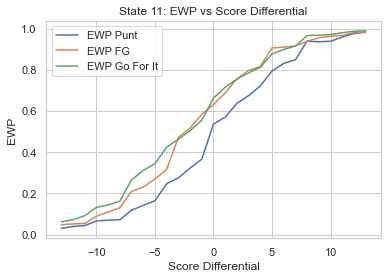

In [377]:
x = df_sweep['score_differential'].to_numpy().flatten()
y_punt = df_sweep['ewp_punt'].to_numpy().flatten()
y_fg = df_sweep['ewp_field_goal'].to_numpy().flatten()
y_go = df_sweep['ewp_go_for_it'].to_numpy().flatten()

plt.plot(x, y_punt, label='EWP Punt')
plt.plot(x, y_fg, label='EWP FG')
plt.plot(x, y_go, label='EWP Go For It')
plt.xlabel('Score Differential')
plt.ylabel('EWP')
plt.title('State 11: EWP vs Score Differential')
plt.legend()
plt.show()
